# InverseStatMech.jl tutorial

A major goal of chemistry and materials science is to design matter at will with our desired properties. Statistical mechanics is the bridge between macroscropic properties and microscopic structures and interactions.

In *forward* statistical mechanics, we start with microscopic interactions and perform simulations to find out statistical properties of the material.

In *inverse* statistical mechanics, we have some prescribed structural descriptors of our material, such as the pair correlation function $g_2(r)$ or the structure factor $S(k)$, and we want to find out the underlying microstructure and intermolecular interactions that realize such correlation functions.

This package collects efficient algorithms to find configurations and interactions that yield your desired pair correlation functions and structure factors.

## Installation

```julia    
import Pkg; Pkg.add("InverseStatMech")
```

## 0. Prelude: Monte-Carlo simulations to obtain pair statistics

This section is on "forward" statistical mechanics, in which we already know the intermolecular interactions and aim to obtain the equilibrium pair statistics at $k_B T = 1$.

First let's create a `Box` with uniformly random particle positions (in periodic boundary conditions) and visualize it:

````julia
    b = InverseStatMech.random_box(dim::Int, n::Int, ρ::Float64, bin_size::Float64, range::Float64)
````

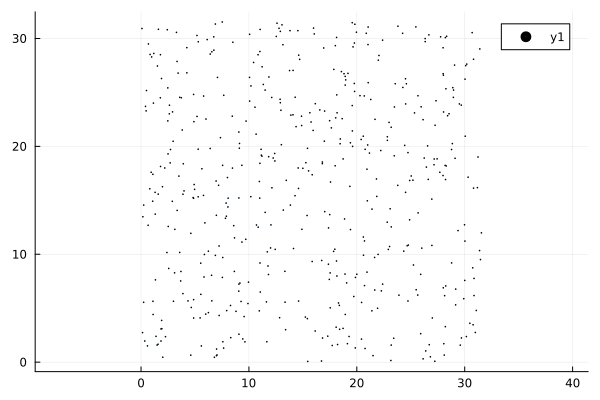

In [2]:
using InverseStatMech
b = InverseStatMech.random_box(2, 500, 0.5, 0.05, 10)
b.visualize()

Compute the pair correlation function $g_2(r)$ for this box:

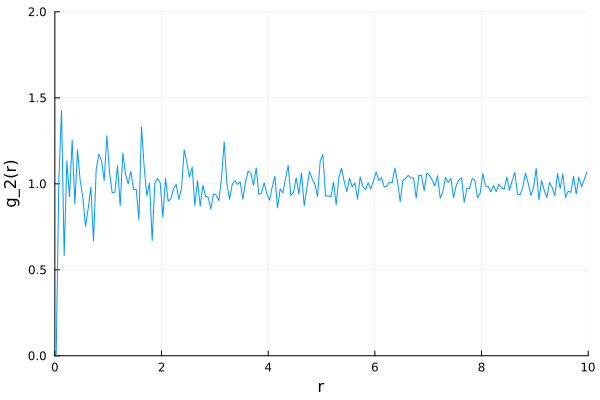

In [3]:
g2_data = b.compute_g2()
using Plots
plot(g2_data[:, 1], g2_data[:, 2], xlims = (0, 10), ylims = (0, 2), xlabel = "r", ylabel = "g_2(r)", legend = false)

Compute the structure factor $S(k)$ for this box:

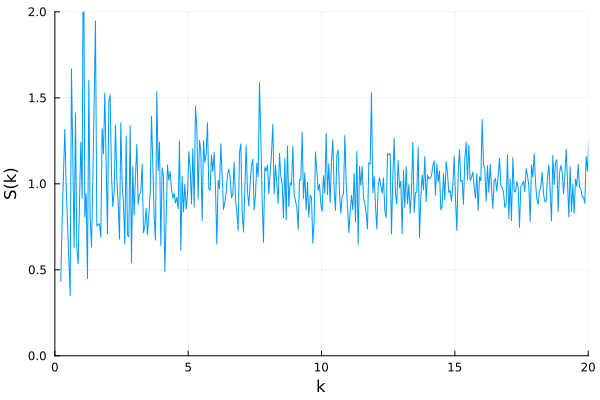

In [4]:
s_data = b.compute_s()
plot(s_data[:, 1], s_data[:, 2], xlims = (0, 20), ylims = (0, 2), xlabel = "k", ylabel = "S(k)", legend = false)

Define a Lennard-Jones pair potential $v(r) = Ar^{-12} - Br^{-6}$ and simulate the box equilibrated under $v(r)$.

In [5]:
lj_pot(r, params) = params[1]*r^(-12) - params[2]*r^(-6)
lj_params = [4.0, 4.0] #avoid write integer vector [4, 4] here... Optim.jl doesn't like it.
InverseStatMech.equilibrate!(b, lj_pot, lj_params; show_pb = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


(::InverseStatMech.var"#faster_f#1"{Float64, Vector{Float64}}) (generic function with 1 method)

Visualize the box again. The particles arrangement becomes much more ordered!

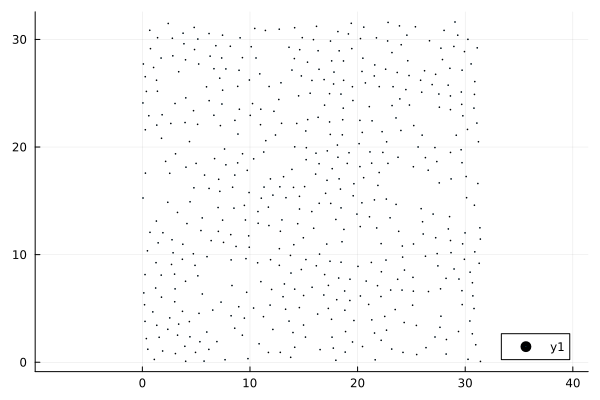

In [10]:
b.visualize()

Now we create an ensemble of 300 boxes with 15 threads, and compute their average $g_2(r)$ and $S(k)$.

In [6]:
#This code takes about 15 minutes on 15 threads. Please be patient.
box_arr, thread_arr = InverseStatMech.simu_boxes(lj_pot, lj_params, 2, 500, 0.5, 0.05, 10, missing, missing;
    n_threads = 15, configs_per_thread = 20, displace = 0.2, show_pb = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:33
Progress: 100%|█████████████████████████████████████████| Time: 0:13:44


(Box[Box([8.167302568003599 0.8040594397915114 … 23.452307618268396 27.81418469987094; 12.664902502478391 6.396086674777642 … 27.440439292818688 9.875588707816368], 31.622776601683793, 0.05, 10, 22, Vector{Any}[[83] [] … [] []; [382] [439] … [] [450]; … ; [437] [148] … [256] []; [255, 60, 219] [164] … [25] [447]], [-3.40179382282358, -2.332846143615064, -2.1610404464367825, -3.7339280662741126, -1.8701318245880012, -2.275176772072727, -2.9633569867996314, -3.048735602009876, -1.7140269705172249, -1.7191987593571203  …  -2.1285678785446227, -2.5712491014933776, -1.4176524820766105, -0.8565062018015983, -2.6420173092517074, -2.6319191144641367, -3.0484578086837804, -5.929632680500994, -1.8528735026368628, -2.8296596012807202], InverseStatMech.var"#18#34"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#19#35"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#20#36"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#21#37"{Box}(Box(#= circular reference

In [8]:
size(box_arr)

(300,)

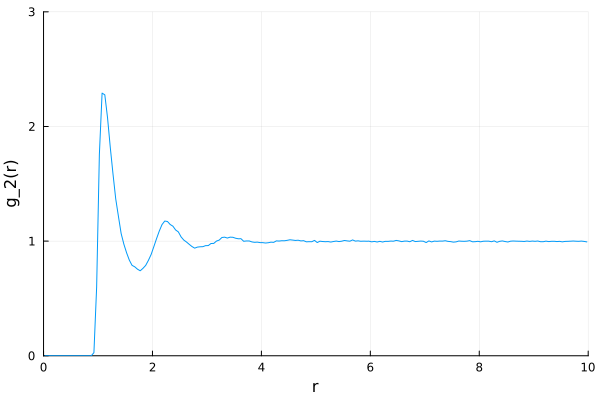

In [9]:
g2_data = InverseStatMech.g2_boxes(box_arr)
plot(g2_data[:, 1], g2_data[:, 2], xlims = (0, 10), ylims = (0, 3), xlabel = "r", ylabel = "g_2(r)", legend = false)

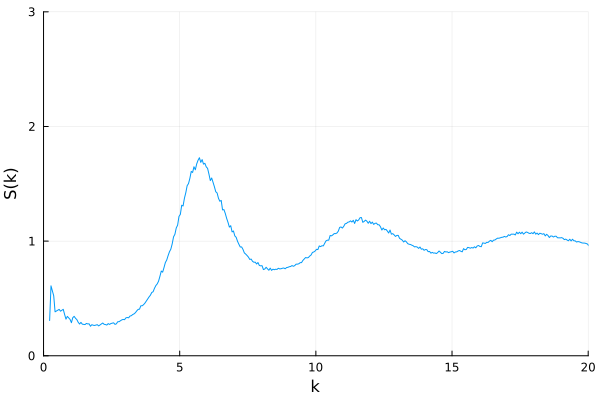

In [10]:
s_data = InverseStatMech.s_boxes(box_arr)
plot(s_data[:, 1], s_data[:, 2], xlims = (0, 20), ylims = (0, 3), xlabel = "k", ylabel = "S(k)", legend = false)

## 1. Torquato-Wang inverse algorithm

[This algorithm](https://torquato.princeton.edu/wp-content/uploads/2022/10/paper456.pdf) enables one to optimize a parametrized potential so that the equilibrated state matches the target $g_2(r)$ and $S(k)$.

- Simulate under a potential $v(r, \mathbf{a})$ with intial parameters $\mathbf{a}$.
- Obtain an ensemble of equilibrium configurations $\mathbb{E}$. Compute simulated $g_2(r)$ and $S(k)$ for each configuration.
- Compute the loss function $\Psi(\mathbf{a}) = \rho\int(g_{2, simu}(r; \mathbf{a}) - g_{2, targ}(r))^2 d\mathbf{r} + \frac{1}{\rho(2\pi)^d}\int(S_{simu}(k; \mathbf{a}) - S_{targ}(k))^2 d\mathbf{k}$
- Compute $\nabla_{\mathbf{a}} \Psi(\mathbf{a})$ via automatic differentiation. Given the set of configurations $\mathbb{E}$, we can estimate $\Psi$ at $\mathbf{a}'$ close to $\mathbf{a}$ by reweighing the pair statistics of each configurations by a boltzmann factor.

    For example,
$$ g_{2, simu}(r, \mathbf{a}') \approx \frac{1}{|\mathbb{E}|}\sum_{C \text{ in } \mathbb{E}} \exp\left(-\frac{\sum_{i<j\text{ in }C} v(r_{ij}; \mathbf{a}')}{\sum_{i<j\text{ in }C} v(r_{ij}; \mathbf{a})}\right)g_{2, C}(r) $$

- Optimize $\Psi$ on $\mathbf{a}$ using BFGS in `Optim.jl` with `ForwardDiff`. 
- Simulate under the optimized $\mathbf{a}$, iterate the steps above until convergence threshold is reached.

In [11]:
?optim_parametrized_pot

search: optim_parametrized_pot



```
optim_parametrized_pot(my_params, pot, dim, ρ, targ_g2, targ_s; 
    large_r_grid = missing, n::Int = 600, bin_size::Float64 = 0.05, r_range::Float64 = 10, k_range::Float64 = 10,
    g2_weight_range::Float64 = 2, s_weight_range::Float64 = 4, 
    n_threads::Int = 15, configs_per_thread::Int = 10, displace = 0.2, Ψ_tol::Float64 = 0.005, show_pb::Bool = true, test::Bool = false)
```

Using the Torquato-Wang algorithm to perform iterative optimization of potential parameters to match target pair correlation function and structure factor.

## Arguments

  * `my_params::Vector{Float64}`: Vector of initial potential parameters.
  * `pot::Function`: Potential function that calculates the interaction potential between particles.
  * `dim::Int`: Dimension of the system.
  * `ρ::Float64`: Density of the system.
  * `targ_g2::Function`: Function representing the target pair correlation function. Accepts a distance value `r` and returns the target g2 value at that distance.
  * `targ_s::Function`: Function representing the target structure factor. Accepts a wave vector `k` and returns the target S value at that wave vector.

## Keyword Arguments (all are optional)

  * `large_r_grid::Missing`: Large-r grid for computation of long-ranged potentials. Default value is `missing`.
  * `n::Int`: Number of boxes for simulation. Default value is `600`.
  * `bin_size::Float64`: Size of the bin for pair correlation function and structure factor calculations. Default value is `0.05`.
  * `r_range::Float64`: Range of r values for pair correlation function calculation. Default value is `10`.
  * `k_range::Float64`: Range of k values for structure factor calculation. Default value is `10`.
  * `g2_weight_range::Float64`: Weight range for pair correlation function in the objective function. Default value is `2`.
  * `s_weight_range::Float64`: Weight range for structure factor in the objective function. Default value is `4`.
  * `n_threads::Int`: Number of threads for parallel computation. Default value is `15`.
  * `configs_per_thread::Int`: Number of configurations to generate per thread for simulation. Default value is `10`.
  * `displace::Float64`: Kick size in the metropolis Monte Carlo simulation. Default value is `0.2`.
  * `Ψ_tol::Float64`: Tolerance for convergence of the objective function. Default value is `0.005`.
  * `show_pb::Bool`: Boolean indicating whether to display a progress bar during simulation. Default value is `true`.
  * `test::Bool`: Boolean flag to indicate whether this is a test run and return a boolean indicating convergence. Default value is `false`.

## Returns

  * If `test` is true, returns `true` if convergence is achieved, `false` otherwise.
  * If `test` is false, returns the optimized potential parameters.

## Example

```
#form of the pair potential
pot(r, params) = params[1]*exp(-(r/params[2])^2)

#initial guess parameters
my_params = [1.0, 2.0] #write 1.0 instead of 1 to indicate that this is Float64

#target pair correlation function and structure factor
targ_g2(r) = 1 
targ_s(r) = 1

#optimize the parameters
InverseStatMech.optim_parametrized_pot(my_params, pot, 2, 1, targ_g2, targ_s)
```


In [12]:
using Interpolations

#prepare the target pair statistics
g2_targ = Interpolations.linear_interpolation(g2_data[:, 1], g2_data[:, 2], extrapolation_bc = Flat())
s_targ = Interpolations.linear_interpolation(s_data[:, 1], s_data[:, 2], extrapolation_bc = Flat())

397-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Flat()) with element type Float64:
 0.3077608269209786
 0.6100934040418968
 0.5667064827872305
 0.5233195615325641
 0.38341799719806763
 0.3905556011700003
 0.39769320514193307
 0.4048308091138662
 0.3890240935972794
 0.39721438777653867
 0.4054046819557981
 0.3605481544343107
 0.31961464521235217
 ⋮
 1.0034727219364714
 1.0022707244821483
 0.9921152420361401
 0.99618182894805
 0.994123112340875
 0.9890073195551922
 0.984219413819373
 0.9831804381935755
 0.9828308927254958
 0.9794185325174741
 0.9747068541922693
 0.9575823560221535

In [ ]:
#optimize the potential parameters
lj_params_guess = [3.0, 2.0] #do not use integer vector here
optim_parametrized_pot(lj_params_guess, lj_pot, 2, 0.5, g2_targ, s_targ; n = 500, configs_per_thread = 10)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


round 1


Progress: 100%|█████████████████████████████████████████| Time: 0:06:34



g2:
 0.024999999999999974  0.0
 0.07500000000000005   0.0
 0.1250000000000003    0.0
 0.17500000000000032   0.0
 0.22500000000000017   0.0
 0.27499999999999997   0.0
 0.32499999999999996   0.0
 0.3750000000000003    0.0
 0.4250000000000009    0.0
 0.4749999999999993    0.0
 0.525                 0.0
 0.5750000000000015    0.0
 0.624999999999999     0.0
 0.6749999999999984    0.0
 0.7250000000000021    0.0
 0.7749999999999989    0.0
 0.8249999999999973    0.0
 0.8750000000000024    0.0
 0.9249999999999984    0.03193422425714134
 0.9749999999999968    0.40569547203185363
 1.0250000000000024    1.1787506783583965
 1.0749999999999995    1.777876687705855
 1.1249999999999982    1.942265621367271
 1.175000000000003     1.8445899878166125
 1.2249999999999985    1.746434257714565
 1.2749999999999961    1.57675322235335
 1.324999999999999     1.4175720576553341
 1.375000000000003     1.3415777835725906
 1.4250000000000007    1.1968153886698927
 1.4750000000000034    1.1141205688620468
 1.52499

  7.72369176531593     0.8303266870357946
  7.773691765315894    0.8094279597460436
  7.823691765315922    0.8348208974278947
  7.873691765315948    0.8149956232238852
  7.923691765315913    0.7937877262032207
  7.973691765315944    0.8113738961867323
  8.023691765315906    0.8039082368417197
  8.073691765315935    0.790278115738122
  8.123691765315915    0.7881367856253844
  8.173691765315938    0.8024685794408912
  8.223691765315904    0.8030733796781723
  8.273691765315935    0.7942222011077715
  8.323691765315901    0.7739820716620552
  8.37369176531592     0.8089101503171435
  8.42369176531595     0.7902710501246066
  8.473691765315918    0.8116642055546319
  8.523691765315947    0.7821099911958908
  8.573691765315917    0.7905819845252339
  8.623691765315932    0.8089285697221015
  8.673691765315903    0.8070316737053874
  8.723691765315946    0.7942607288641623
  8.773691765315919    0.8125152892858385
  8.823691765315925    0.8229633552228093
  8.8736917653159      0.8164203148

Progress: 100%|█████████████████████████████████████████| Time: 0:08:13



g2:
 0.024999999999999974  0.0
 0.07500000000000005   0.0
 0.1250000000000003    0.0
 0.17500000000000032   0.0
 0.22500000000000017   0.0
 0.27499999999999997   0.0
 0.32499999999999996   0.0
 0.3750000000000003    0.0
 0.4250000000000009    0.0
 0.4749999999999993    0.0
 0.525                 0.0
 0.5750000000000015    0.0
 0.624999999999999     0.0
 0.6749999999999984    0.0
 0.7250000000000021    0.0
 0.7749999999999989    0.0
 0.8249999999999973    0.0
 0.8750000000000024    0.00019401745443583388
 0.9249999999999984    0.03432011457520364
 0.9749999999999968    0.5275782318697495
 1.0250000000000024    1.4063189560125229
 1.0749999999999995    1.9389562952258397
 1.1249999999999982    2.019074975828923
 1.175000000000003     1.9189977456082281
 1.2249999999999985    1.7158072166929077
 1.2749999999999961    1.57528858078555
 1.324999999999999     1.3892564914277652
 1.375000000000003     1.265646407086566
 1.4250000000000007    1.133198086504879
 1.4750000000000034    1.0652051

  7.673691765315904    0.8432237119006555
  7.72369176531593     0.8252433360701559
  7.773691765315894    0.835046642763137
  7.823691765315922    0.823611636219409
  7.873691765315948    0.8122527094822308
  7.923691765315913    0.8073229194935606
  7.973691765315944    0.7842000557703419
  8.023691765315906    0.8180154887779982
  8.073691765315935    0.7949421603840797
  8.123691765315915    0.8025343000140565
  8.173691765315938    0.8067213511764466
  8.223691765315904    0.7937694309840445
  8.273691765315935    0.7861776230817427
  8.323691765315901    0.7748021378496147
  8.37369176531592     0.7908614462490285
  8.42369176531595     0.7908737831544025
  8.473691765315918    0.7757674711027038
  8.523691765315947    0.7890944964456604
  8.573691765315917    0.7781274351076725
  8.623691765315932    0.7692873814725901
  8.673691765315903    0.7931449890044263
  8.723691765315946    0.78879892587836
  8.773691765315919    0.8009425350721779
  8.823691765315925    0.8023673812178

Progress: 100%|█████████████████████████████████████████| Time: 0:09:36


### Advantages
- Captures both short- and long-range correlations.
- The fastest inverse algorithm for single-phase liquids so far!

### Limitations and caveats
- Do not apply to states near phase boundaries: The Boltzmann-factor reweighing will fail to capture the true variation of pair statistics on potential parameters there.
- The default BFGS optimization algorithm does not work if the initial gradient norm of the parameters is large (>$10^3$). Will fix this problem in future releases.

## 2. Ornstein-Zernike approximations of the potentials

The Ornstein-Zernike integral equation is a closed-form model between pair statistics and pair potentials. With proper closures, it finds approximate potentials given target pair statistics.

Fourier transform of the total correlation function $c(r)$ can be computed via $S(k)$:

$$ \tilde{c}(k) = \frac{S(k) - 1}{\rho S(k)} $$

The common closures used for the OZ equation are 

- Potential of mean force (PMF): $\beta v(r) = -\ln(g_2(r))$
- Mean-field approximation (MFA): $\beta v(r) = -c(r)$
- Hypernetted chain (HNC): $\beta v(r) = g_2(r) - 1 - c(r) - \ln(g_2(r)) $
- Percus-Yevick (PY): $\beta v(r) = \ln(1 - \frac{c(r)}{g_2(r)})$

The function `ornstein_zernike_v` enables one to compute the OZ potentials. The $\ln$ in the closures is `NaN` if $g_2(r) = 0$, so we avoid evaluating there, and instead apply linear extrapolations of $v(r)$.

In [13]:
?ornstein_zernike_v

search: ornstein_zernike_v



```
ornstein_zernike_v(dim::Int, ρ::Float64, g2::Function, s::Function, closure::String, r_vec::AbstractVector = 0.025:0.05:10,
k_vec::AbstractVector = 0.025:0.05:20) :: Interpolations.GriddedInterpolation
```

Compute the Ornstein-Zernike potential ($βv(r)$) using the Ornstein-Zernike equation.

## Arguments

  * `dim::Int`: The dimensionality of the system.
  * `ρ::Real`: The number density (particles per unit volume) of the system.
  * `g2::Function`: The pair correlation function $g_2(r)$ as a function of $r$.
  * `s::Function`: The structure factor $S(k)$ as a function of $k$.
  * `closure::String`: The closure relation to be used in the Ornstein-Zernike equation. Possible values are:

      * "PMF": Potential of mean force, basically $-\ln(g_2(r))$.
      * "MFA":Mean-Field Approximation (MFA).
      * "HNC": Hypernetted Chain closure.
      * "PY": Percus-Yevick closure.

## Optional Arguments

  * `r_vec::AbstractVector`: A vector of r values at which the g_2(r) function is valid. Default is 0.025:0.05:10.
  * `k_vec::AbstractVector`: A vector of k values at which the S(k) function is valid. Default is 0.025:0.05:20.

## Returns

  * An instance of `Interpolations.GriddedInterpolation` representing the OZ potential $βv(r)$, which can be used as a regular function.

Note: The `g2` and `s` functions should be provided as valid functions that return the pair correlation function and structure factor, respectively, as a function of r and k.

## Example:

```
function pair_correlation_function(r)
    # Define the pair correlation function here

    # ...
end
function structure_factor(k)
    # Define the structure factor here

    # ...
end
closure_type = "PY"
oz_v = ornstein_zernike_v(3, 0.5, pair_correlation_function, structure_factor, closure_type)
```


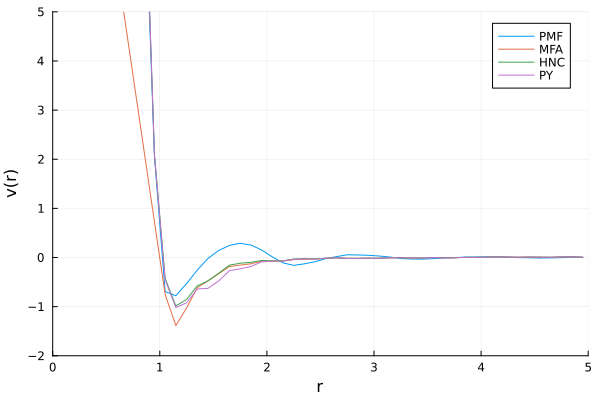

In [16]:
r_vec = 0.05:0.1:5
v_pmf = ornstein_zernike_v(2, 0.5, g2_targ, s_targ, "PMF")
v_mfa = ornstein_zernike_v(2, 0.5, g2_targ, s_targ, "MFA")
v_hnc = ornstein_zernike_v(2, 0.5, g2_targ, s_targ, "HNC")
v_py = ornstein_zernike_v(2, 0.5, g2_targ, s_targ, "PY")
plot(r_vec, [v_pmf.(r_vec), v_mfa.(r_vec), v_hnc.(r_vec), v_py.(r_vec)], xlims = (0, 5), ylims = (-2, 5), 
    xlabel = "r", ylabel = "v(r)", label = ["PMF" "MFA" "HNC" "PY"])

## 3 Iterative Boltzmann inversion

The [IBI algorithm](https://www.sciencedirect.com/science/article/pii/0301010495003576) iteratively updates the potential based on the difference between the potentials of mean force for the target and simulated pair statistics.
- $i = 0$
- Simulate under an initial potential $v_i(r)$.
- Compute ensemble-averaged $g_{2,i}(r)$.
- $v_{i+1}(r) = v_i(r) + \alpha\ln(\frac{g_{2,i}(r)}{g_{2, targ}(r)})$
- $i = i+1$. Repeat until converge threshold reached.

In [17]:
?iterative_boltzmann

search: iterative_boltzmann



```
iterative_boltzmann(pot::Function, dim::Int, ρ::Float64, targ_g2::Function, α = 1; n = 500, bin_size = 0.05, r_range = 10)::Function
```

Iteratively updates the pair potential `pot` using the Boltzmann inversion method to match the target pair correlation function `targ_g2`.

# Arguments

  * `pot::Function`: The initial pair potential function to be optimized.
  * `dim::Int`: The dimensionality of the system.
  * `ρ::Float64`: The number density of particles in the system.
  * `targ_g2::Function`: The target pair correlation function `g_2(r)`.
  * `α::Float64`: The update parameter for the potential. (Optional, default: 1)

# Keyword Arguments (All are optional)

  * `n`: Number of configurations for each box in the simulation. (default: 500)
  * `bin_size`: Bin size for the histograms of pair correlation functions. (default: 0.05)
  * `r_range`: Maximum distance to compute the pair correlation function. (default: 10)
  * `n_threads`: Number of threads to use for parallel computation. (default: 15)
  * `configs_per_thread`: Number of configurations to generate for each thread. (default: 10)
  * `displace`: Kick size in the metropolis Monte Carlo simulation. Default value is 0.2.
  * `Ψ_tol`: Tolerance for stopping criterion. (default: 0.005)
  * `show_pb`: Whether to show the progress bar during the simulation. (default: true)
  * `test`: Whether to run the function in test mode. (default: false)

# Returns

  * If `test=true`, returns a boolean indicating whether the optimization is successful.
  * Otherwise, returns the optimized pair potential function.

# Example

```
optimized_potential = iterative_boltzmann(r -> 0, 2, 1.0, r -> 1 - exp(-π*r^2))
```


In [18]:
optimized_potential = iterative_boltzmann(r -> 0, 2, 0.5, g2_targ)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


round 1


Progress: 100%|█████████████████████████████████████████| Time: 0:06:44



g2:
 0.024999999999999974  0.964266748546097
 0.07500000000000005   1.0050104139776228
 0.1250000000000003    0.9669829929081983
 0.17500000000000032   0.9594163121852033
 0.22500000000000017   1.0087829755916526
 0.27499999999999997   0.9500681984714738
 0.32499999999999996   0.9893397734270339
 0.3750000000000003    0.98735482562396
 0.4250000000000009    0.9706579117510412
 0.4749999999999993    0.9842811806878976
 0.525                 0.9849619436859205
 0.5750000000000015    0.9929054119291244
 0.624999999999999     0.9876264500601708
 0.6749999999999984    0.9954532578887432
 0.7250000000000021    1.0000930750462307
 0.7749999999999989    1.001067478613279
 0.8249999999999973    0.9895772073747706
 0.8750000000000024    0.9681470976348115
 0.9249999999999984    0.9754620800385417
 0.9749999999999968    0.9795891526400041
 1.0250000000000024    0.9818229621060254
 1.0749999999999995    0.9521068173901771
 1.1249999999999982    1.0069721460169223
 1.175000000000003     0.98391617

round 2


Progress: 100%|█████████████████████████████████████████| Time: 0:06:44



g2:
 0.024999999999999974  0.0
 0.07500000000000005   0.0
 0.1250000000000003    0.0
 0.17500000000000032   0.0
 0.22500000000000017   0.0
 0.27499999999999997   0.0
 0.32499999999999996   0.0
 0.3750000000000003    0.0
 0.4250000000000009    0.0
 0.4749999999999993    0.0003574005739607471
 0.525                 0.00032336242405972353
 0.5750000000000015    0.0005904879048047125
 0.624999999999999     0.0
 0.6749999999999984    0.0007545123228060212
 0.7250000000000021    0.0
 0.7749999999999989    0.0008762078587424769
 0.8249999999999973    0.001234656528228037
 0.8750000000000024    0.005432488724203348
 0.9249999999999984    0.044597795945318146
 0.9749999999999968    0.8096497617803091
 1.0250000000000024    2.0562301070422184
 1.0749999999999995    2.5047878969357407
 1.1249999999999982    2.390596843578607
 1.175000000000003     2.202180668465638
 1.2249999999999985    1.9331067656610412
 1.2749999999999961    1.6451919283396392
 1.324999999999999     1.4165470597828447
 1.375

 6.974999999999999      0.005684732166391809
 7.025000000000022      0.005612919536392991
 7.0749999999999895    -0.010109849251637347
 7.125000000000018      0.007445730415605302
 7.174999999999984      0.015806385137690337
 7.2250000000000085    -0.0001059016645214125
 7.274999999999992     -0.006234631058448314
 7.325000000000017     -0.0006723156891237524
 7.374999999999983     -0.0022734328278972288
 7.425000000000012      0.0064511564598168794
 7.4749999999999766     0.008822033816150052
 7.525000000000003      0.002761475222549195
 7.57500000000003       0.004208732003956813
 7.624999999999994     -0.0008122618600088388
 7.675000000000021     -0.0021831529175500384
 7.724999999999989      0.002868338715898662
 7.775000000000016     -0.0005570270192948945
 7.82499999999998      -0.006218938991350219
 7.875000000000023      0.007946318075901397
 7.924999999999986     -0.0034934156675936615
 7.975000000000015      0.004859359557620591
 8.02499999999998      -0.0018426117037534833
 

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:49

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
     [1] [0m[1m(::InverseStatMech.var"#27#43"{Box})[22m[0m[1m([22m[90mj[39m::[0mInt64, [90mpair_pot[39m::[0mInverseStatMech.var"#faster_f#1"[90m{Float64, Vector{Float64}}[39m, [90muse_cl[39m::[0mBool, [90miso[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mInverseStatMech[39m [90m~/InverseStatMech/src/[39m[90m[4mbox.jl:115[24m[39m
     [2] [0m[1m(::InverseStatMech.var"#31#47"{Box})[22m[0m[1m([22m[90mj[39m::[0mInt64, [90mdisplace[39m::[0mFloat64, [90mtemperature[39m::[0mInt64, [90mpair_pot[39m::[0mFunction, [90muse_cl[39m::[0mBool, [90miso[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mInverseStatMech[39m [90m~/InverseStatMech/src/[39m[90m[4mbox.jl:150[24m[39m
     [3] [0m[1mequilibrate![22m[0m[1m([22m[90mb[39m::[0mBox, [90mpair_pot[39m::[0mInverseStatMech.var"#81#85", [90mpot_params[39m::[0mVector[90m{Int64}[39m, [90muse_cl[39m::[0mBool, [90mlarge_r_grid[39m::[0mMissing, [90mpair_pot_faster[39m::[0mInverseStatMech.var"#faster_f#1"[90m{Float64, Vector{Float64}}[39m; [90mtemperature[39m::[0mInt64, [90msweeps[39m::[0mInt64, [90mdisplace[39m::[0mFloat64, [90mshow_pb[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mInverseStatMech[39m [90m~/InverseStatMech/src/[39m[90m[4mbox.jl:210[24m[39m
     [4] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m~/InverseStatMech/src/[39m[90m[4mbox.jl:279[24m[39m[90m [inlined][39m
     [5] [0m[1m(::InverseStatMech.var"#63#65"{Int64, Float64, InverseStatMech.var"#81#85", Vector{Int64}, Missing, ProgressMeter.Progress, Vector{Box}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mInverseStatMech[39m [90m./[39m[90m[4mthreadingconstructs.jl:178[24m[39m

### Advantages
- Fast

### Limitations
- Uses binned potential: prone to noise in simulated $g_2(r)$
- Only targets $g_2(r)$ and does not consider long-ranged correlations

## 4. Reverse Monte Carlo: Find configurations that match target $g_2(r)$

The [reverse Monte Carlo algorithm](https://iopscience.iop.org/article/10.1088/0953-8984/13/46/201) performs a simulated annealing optimization to find configurations that match a target $g_2(r)$.

In [19]:
?reverse_mc

search: reverse_mc reverseind reverse! reverse bitreverse



```
reverse_mc(dim::Int, n::Int, ρ::Float64, g2_targ::Function; initial_box = missing, bin_size = 0.05, range = 5, sweeps = 100, displace = 0.1, t_i = 1, t_f = 0.001, cooling_rate = 0.98)
```

Reverse Monte Carlo algorithm to generate equilibrium configurations that yield a target pair correlation function $g_2(r)$.

# Arguments

  * `dim::Int`: Dimensionality of the system.
  * `n::Int`: Number of particles.
  * `ρ::Float64`: Number density of the particles.
  * `g2_targ::Function`: Target pair correlation function as a function `g2_targ(r)`.

# Keyword arguments

  * `initial_box::Box` (optional): Initial configuration box. Default is `missing` which generates a random box.
  * `bin_size::Float64` (optional): Bin size for computing the pair correlation function. Default is 0.05.
  * `range::Float64` (optional): Range for the interaction potential. Default is 5.
  * `sweeps::Int` (optional): Number of Monte Carlo sweeps at each temprature. Default is 100.
  * `displace::Float64` (optional): Maximum displacement for particle moves. Default is 0.1.
  * `t_i::Float64` (optional): Initial temperature. Default is 1.
  * `t_f::Float64` (optional): Final temperature. Default is 0.001.
  * `cooling_rate::Float64` (optional): Cooling rate for temperature reduction. Default is 0.98.

# Returns

  * `b::Box`: Generated equilibrium classical configuration box. Use `b.particles'` to get the particle positions.

# Example

```
box = InverseStatMech.reverse_mc(2, 100, 0.5, r -> 1 - exp(-π*r^2))
```


In [21]:
using Interpolations
g2_targ = Interpolations.linear_interpolation(g2_data[:, 1], g2_data[:, 2], extrapolation_bc = Flat())
box = InverseStatMech.reverse_mc(2, 200, 0.5, g2_targ; t_i = 0.5, t_f = 0.45)

Initial g2:
100×2 Array{Float64, 2}:
 0.025  0.0
 0.075  1.69765272631355
 0.125  1.5278874536821954
 0.175  1.0913481812015684
 0.225  1.4147106052612919
 0.275  0.9259923961710267
 0.325  0.9794150344116627
 0.375  1.697652726313548
 0.425  0.7489644380795067
 0.475  1.2062269371175212
 0.525  1.3338699992463598
 0.575  0.8857318572070689
 0.625  0.8148733086305042
 0.675  0.6601982824552686
 0.725  0.9659058615232258
 0.775  0.9857338410852868
 0.825  0.6944942971282708
 0.875  1.0185916357881282
 0.925  1.1700039059728522
 0.975  1.2405923769214404
 1.025  0.9316386912696328
 1.075  1.0659679909410684
 1.125  0.7922379389463272
 1.175  1.3545101539735798
 1.225  0.883472337163176
 1.275  1.1983431009272176
 1.325  0.9128887301874788
 1.375  0.8796927763624809
 1.425  1.2509020088626208
 1.475  0.7337312630677232
 1.525  1.0018934122506251
 1.575  0.8488263631567793
 1.625  1.0577682371646018
 1.675  1.178221668262396
 1.725  1.1809758096094334
 1.775  1.1118429827264842
 1.825  1.1

  1.4894531910942883   11.142620988123548
 12.450290410052263     9.528149927180216
  8.591827458091757    14.425094881868361
  6.432606642865892    13.551013945099603
 15.836672724625476    12.004262042988703
 16.151604133059333     0.3102710351790603
  4.069413897128384     0.8426456199088017
  9.296951878654648    17.604684171293858
  5.123503468105812     2.6923738254322602
 14.711950567734798     9.043495400807773
  3.866107805019716     0.7904286624941199
 16.39161205289465     17.00817562100042
 17.745796352016704     4.333822493983019
 15.282823828175912    11.56769026842142
  8.605326388908598    13.592133824649327
  0.719922288798439     5.413152743076353
 11.176783780593093    10.72773560016719
  1.3196235397874312   11.148754139326343
 14.62219982552412     12.383916855859255
 13.946711581117794    13.881809517711444
  3.7474719361582434    0.3904053478116325
  3.865472794297167     7.925673518471635
 15.845521490638976     9.945677750181387
  2.9573718583095983    0.566361

 11.451900828116433    12.57482918810709
  3.024320319451794     7.444439865187682
  0.7718118503530748   16.58052121089309
 19.948072177614026     9.39377179018518
 17.712809678109604    16.011301911766694
 14.642940290217124     6.325497849731751
 18.69544532306208     15.38061110911954
  8.695704749857343     6.7263172261324575
  2.1035985860148654   10.269513976354176
  4.988203645426686    12.71586801510453
  7.485756335775487     0.9312833683006368
 14.449210667272629     6.59396654843892
  7.428889292426017    10.697227956057104
 14.411980676353997     2.388194935489088
  3.388072112366344    18.006156980122707
  3.8835366668672635   13.980407954037641
 19.52583754384576     14.266029951023915
  6.050545390078923    14.40580354425739
 18.482716345332534    17.37054800336433
 12.809652343155337     9.208849563726814
  5.940987249281868     7.731739219643346
 14.729737094428588    13.317015997539755
 18.44006527404528      5.442899843072805
  0.693331637905597    18.47924723867533

 11.575588661746913    12.516704329801168
  2.964598008115769     6.459449641812511
  1.3987901182831526   17.092331503205486
 19.17282260675841      9.203428654285537
 18.590690274862094    15.398704304567367
 14.86809935768738      6.134752361886768
 18.8925032892063      14.927387321773452
  8.558433999420764     6.652812048029612
  2.4090485992728197   11.024491439378885
  4.492668246657713    12.58403822063296
  7.354504938987418     1.083879858125745
 14.24644990146678      6.201689097311611
  7.280688912838139    10.464933979617129
 14.608024277043974     2.5598920540395174
  2.2224290366396726   17.219307656794435
  3.5390414206796366   14.746483361899994
 19.80946522094876     14.839037691012882
  5.830746046512448    13.677077202215417
 19.54086181375678     17.55207628637533
 12.298092016313916     8.83850294596011
  6.610409150022215     8.174027734756658
 15.36580461563759     12.98190429196784
 18.33263082871534      4.703345367132399
  0.5227238890500464   18.86325804424

 15.081354819194742     2.416547580485029
 11.058443758258937    12.715538711533974
  2.4111118350838026    6.11610046350256
  1.6845116090512984   17.575242361553848
 19.062374273842593     9.791153837350707
 19.142074865635223    14.462496628115852
 14.791436884438173     5.722082254299645
 19.51389952490964     14.969978763230104
  8.175983122882837     6.965320809368287
  3.168534360499958    10.764197322907071
  4.609754217427444    11.679678138289947
  7.221646314063942     0.9032979546823849
 13.848568285972865     6.419774396674082
  7.630550283689328     9.758856132389427
 15.024527392276037     2.308450148341616
  2.88045550642076     17.805559174448433
  3.134496925865004    15.041727430782329
 19.729492732250876    15.19122531434988
  5.809273633962403    13.801835363245518
  0.1381261061806212   17.50284939202134
 13.991864302627596     8.623004084255008
  7.389809200727842     7.780821795248982
 15.758003181669865    13.802381479734208
 18.4483262916931       5.4402755869

 11.533785489068912    12.262923841716912
  2.986093459400166     5.160548722207721
  1.6280945079706413   16.81338593608133
 19.310069384600308     9.769614563452585
 19.941478010727312    14.78521641007252
 15.096136577272809     5.802419906033536
 19.001322252360346    15.025806676723487
  7.738427901643689     6.48897797544423
  3.8309342802259256   11.449480151342376
  5.088677511931924    10.440700840519279
  7.726421367646667     0.35959976837694574
 13.80538036368901      6.602171742043995
  8.671190582695306    10.086761183899634
 15.588477743944216     2.6819148314606953
  3.8441914362163034   17.722499485991747
  3.122191306844358    15.850212398609886
 19.614368014705693    16.115406772686526
  5.7536615911588544   14.342282774488401
  0.7721926314127501   18.609052796866678
 14.458651381025872     8.931678408467159
  7.776247894648121     7.365749577652228
 16.16897882845432     14.756924964756546
 18.978278380050845     5.151063782211241
  0.22608780404573148  19.46780322

 10.556560506460524    11.656264671097002
  2.7520603326927904    4.578757765016259
  0.4775533143080501   15.915255392068898
 19.225783593813173    10.666009235651892
 19.740752697804638    14.12603218126716
 15.97562576899636      6.601106062489519
 18.6936088823682      14.763097057018374
  8.238659057543138     6.655187930721333
  4.099045624917647    11.428592592849256
  5.11196589806299     10.533937367796819
  7.064967245537166     0.6684980063863235
 13.815870036553784     5.691388546383991
  9.233793583989302    10.877988000958506
 16.019252502280377     3.160808089979151
  4.287332228363218    17.909439977016
  3.5950099359865995   16.50337453801085
 19.864418788649417    16.88495500605161
  5.872705833290048    14.458108003530059
  0.6391021724245124   18.101472069790447
 15.660085238268957     8.65309834078006
  7.714076125260659     7.224354827010394
 16.724878464338516    14.556476244864612
 19.00185155425398      5.662946360270462
 19.976044102710834    19.00524332753735

Box([15.842346074573129 17.89935628167925 … 19.00185155425398 19.976044102710834; 18.904102926880306 19.33233774667332 … 5.662946360270462 19.005243327537354], 20.0, 0.05, 5, 14, Vector{Any}[[60, 58] [97] … [195] [165]; [] [] … [132, 42] [39]; … ; [144] [82] … [141] [2, 36]; [37] [] … [34, 61] [200]], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], InverseStatMech.var"#18#34"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#19#35"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#20#36"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#21#37"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#22#38"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#24#40"{Int64, Box}(2, Box(#= circular reference @-2 =#)), InverseStatMech.var"#25#41"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#26#42"{Box}(Box(#= circular reference @-2 =#)), InverseStatMech.var"#27#43"{Bo

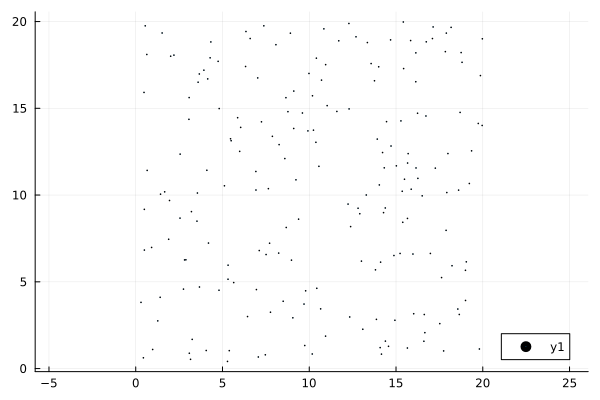

In [22]:
box.visualize()

### Advantages:
- Simple concept.
- Simply probes realizability of pair statistics without considering intermolecular forces. 

### Limitations:
- Slow. The slower the better because it's simulated annealing!
- Generates only configurations, but not intermolecular potentials.

## Future works

- Iterative OZ inversion for other OZ closures
- Multi-component systems
- Particle-less simulations of pair statistics